<a href="https://colab.research.google.com/github/SamarjeetSinghOp/Kuk-v2.0/blob/main/YOLOX-Object-Detection-Paper-Explanation-and-Custom-Training/YOLOX_training_on_custom_drone_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training YOLOX on a Custom Drone Dataset
<img src="https://learnopencv.com/wp-content/uploads/2022/10/yolox-object-detector-paper-explnation-and-custom-training.gif" alt="yolox" width="1000">

In this notebook, we will cover the following.

* How to install YOLOX?
* Configuring Training Parameters.
* Train YOLOX on a custom Drone dataset.
* Evaluate
* Inference

Check out accompanying blog post [YOLOX Object Detector Paper Explanation and Custom Training](https://learnopencv.com/yolox-object-detector-paper-explanation-and-custom-training/).


## 1. Clone YOLOX Repository

In [1]:
!git clone https://github.com/Megvii-BaseDetection/YOLOX.git

Cloning into 'YOLOX'...
remote: Enumerating objects: 1940, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1940 (delta 5), reused 1 (delta 1), pack-reused 1924 (from 3)
Receiving objects: 100% (1940/1940), 7.56 MiB | 35.01 MiB/s, done.
Resolving deltas: 100% (1152/1152), done.


## 2. Install Requirements

In [2]:
%cd YOLOX
!pip3 install -v -e .

/content/YOLOX
Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
Obtaining file:///content/YOLOX
  Running command python setup.py egg_info
  /usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!

          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************

  !!
    dist.fetch_build_eggs(dist.setup_requires)
  running egg_info
  creating /tmp/pip-pip-egg-info-7vt8v641/yolox.egg-info
  writing /tmp/pip-pip-egg-info-7vt8v641/yolox.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-7vt8v641/yolox.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-7vt8v641/yolox.

## 3. Define Classes
Since we are using VOC format, by default there will be 20 classes. It is defined in `yolox/data/datasets/voc_classes.py` file. We will modify it to contain only **drone** class.

In [3]:
from IPython.core.magic import register_line_cell_magic
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [4]:
%%writetemplate yolox/data/datasets/voc_classes.py

VOC_CLASSES = (
  "drone",
)

In [5]:
%%writetemplate yolox/data/datasets/coco_classes.py

COCO_CLASSES = (
  "drone",
)

## 4. Download Pre-trained YOLOX medium weights

Available in [YOLOX GitHub releases](https://github.com/Megvii-BaseDetection/YOLOX/releases).

In [6]:
!wget https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_m.pth

--2025-07-31 05:44:36--  https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_m.pth
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/386811486/a0b0f1ca-0e3c-43e4-829d-d9177f6be5f7?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-07-31T06%3A35%3A03Z&rscd=attachment%3B+filename%3Dyolox_m.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-07-31T05%3A34%3A57Z&ske=2025-07-31T06%3A35%3A03Z&sks=b&skv=2018-11-09&sig=KIOvT597fv2%2F2E%2BstnsBExMaH72svkO6mPqyBmuY87M%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1Mzk0MDk3NiwibmJmIjoxNzUzOTQwNjc2LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvb

## 5. Download Drone Dataset
The dataset is in following order.
```
VOCdevkit
  |___VOC2012
     |___Annotations
     |___ImageSets
            |___Main
                   |___train.txt
                   |___valid.txt
     |___JPEGImages
```

In [7]:
%cd datasets
!wget https://github.com/spmallick/learnopencv/blob/master/YOLOX-Object-Detection-Paper-Explanation-and-Custom-Training/Drone-dataset.zip?raw=true -O VOCdevkit.zip -q --show-progress
!unzip -qq VOCdevkit.zip
!rm VOCdevkit.zip
%cd ..

/content/YOLOX/datasets
VOCdevkit.zip       100%[===================>]  50.28M  --.-KB/s    in 0.1s    
/content/YOLOX


## 6. Configuring Training Parameters
In YOLOX, training params are stored in python scripts called experiment files. Example scripts are available in `exps/example/yolox_x_voc/` directory.

These scripts contain definition of the following parameters that we need to modify.

* **Network depth and width** : [Check out the blog post for defaults](https://learnopencv.com/yolox-object-detector-paper-explanation-and-custom-training/).
* **Number of Epochs**
* **Number of classes**
* **Augmentation info**
* **Path to Training and Validation Dataset**


Rest of the defaults are available in `yolox/exp/yolox_base.py`.

Note that YOLOX has already set the prefixes for Train and validation data path. It is, <br><br> `datasets/VOCdevkit/VOC` + `str(year)` + `/ImageSets/Main`.

Hence, we only need to specify **2012** or **2007**.

i.e.,
```
image_sets=[('2012', 'train)],
image_sets=[('2012','valid')],
```

in the `get_dataloader` and `get_eval_loader` functions respectively.

In this notebook, we will go through the training pipeline of the **YOLOX Medium** model. You can easily switch between models using the correct configurations. We have already created the model specific scripts for you. Go ahead and download `exp.py` files.

### 6.1 Download Exp config files

In [8]:
# Download experiment config files.
%cd exps
!wget https://github.com/spmallick/learnopencv/blob/master/YOLOX-Object-Detection-Paper-Explanation-and-Custom-Training/ExpConfigs.zip?raw=true -O custom_exps.zip -qq --show-progress
!unzip custom_exps.zip
%cd ..

/content/YOLOX/exps
custom_exps.zip     100%[===================>]   7.46K  --.-KB/s    in 0s      
Archive:  custom_exps.zip
   creating: ExpConfigs/
  inflating: ExpConfigs/yolox_voc_l.py  
  inflating: ExpConfigs/yolox_voc_m.py  
  inflating: ExpConfigs/yolox_voc_nano.py  
  inflating: ExpConfigs/yolox_voc_s.py  
  inflating: ExpConfigs/yolox_voc_t.py  
/content/YOLOX


We have set the parameters in the scripts as follows.

* **Depth** : 0.67
* **Width** : 0.75
* **Epochs** : 300
* **Number of Classes** : 1
* **Train Data Path** : `image_sets=[('2012', 'train)],`
* **Validation Data Path** : `image_sets=[('2012','valid')],`
* **Augmentation**
    - Mixup: 1.0
    - Mosaic: 1.0
    - HSV: 1.0
    - FLIP: 0.5

Let's modify number of epochs to 25 using stream editor.

In [11]:
!ls

assets	  docs	      MANIFEST.in	setup.cfg  yolox
build	  exps	      README.md		setup.py   yolox.egg-info
datasets  hubconf.py  requirements.txt	tests	   yolox_m.pth
demo	  LICENSE     SECURITY.md	tools


In [16]:
MAX_EPOCH = 10
!sed -i -e 's/self.max_epoch = 10/self.max_epoch = {MAX_EPOCH}/g' "exps/ExpConfigs/yolox_voc_m.py"

We will keep rest of the params as shown above. Feel free to experiment with the parameters. If you want to create experiment file using the example script from scratch, uncomment the following cell.

In [ ]:
# '''Copy experiment config file fpr medium model.'''

# !cp ./exps/example/yolox_voc/yolox_voc_s.py ./exps/example/yolox_voc/yolox_voc_m.py

# '''Set number of classes.'''
# NUM_CLASSES = 1
# !sed -i -e 's/self.num_classes = 20/self.num_classes = {NUM_CLASSES}/g' "exps/example/yolox_voc/yolox_voc_m.py"

# '''Set maximum number of epochs. Warning! Running this cell multiple times will create two lines'''
#MAX_EPOCH = 25
# !sed -i '/self.max_epoch = 300/self.max_epoch={MAX_EPOCH}' "yolox/exp/yolox_base.py"

# '''Set network depth for medium model.'''
# DEPTH = 0.67
# !sed -i -e 's/self.depth = 0.33/self.depth = {DEPTH}/g' "exps/example/yolox_voc/yolox_voc_m.py"

# '''Set network width for medium model.'''
# WIDTH = 0.75
# !sed -i -e 's/self.width = 0.50/self.width = {WIDTH}/g' "exps/example/yolox_voc/yolox_voc_m.py"

## 7. Train
Let's train the YOLOX medium model. For others, change the exp config file path and pre-trained weights path.

In [21]:
!python tools/train.py -f exps/ExpConfigs/yolox_voc_m.py -d 1 -b 16 --fp16 -o -c yolox_m.pth

2025-07-31 06:07:48.951863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753942068.972787    7377 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753942068.979133    7377 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 06:07:49.000679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/content/YOLOX/yolox/core/trainer.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please us

## 8. Evaluate

In [27]:
MODEL_PATH = "YOLOX_outputs/yolox_voc_m/best_ckpt.pth"
!python3 tools/eval.py -c {MODEL_PATH} -b 16 -d 1 --conf 0.001 -f exps/ExpConfigs/yolox_voc_m.py

2025-07-31 06:22:52.254903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753942972.275795   11423 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753942972.282184   11423 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 06:22:52.302721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-31 06:22:56 | INFO     | __main__:140 - Args: Namespace(experiment_name='yolox_voc_m', name=None, dist_backen

## 9. Image Inference


In [28]:
# Download Images
%mkdir inference_media
%cd inference_media
!wget https://www.dropbox.com/s/1dy29ys1fkce8k3/bird-and-drone.png?dl=1 -O bird-and-drone.jpg -qq --show-progress
!wget https://www.dropbox.com/s/i0afm1nqm6iiuji/eagle-capturing-drone.png?dl=1 -O eagle-capturing-drone.jpg -qq --show-progress
!wget https://www.dropbox.com/s/kje4h0avj2scgjj/eagle-vs-drone.png?dl=1 -O eagle-vs-drone.jpg -qq --show-progress
!wget https://www.dropbox.com/s/jhjy3lfl5908vta/drone-vs-birds.jpg?dl=1 -O drone-vs-birds.jpg -qq --show-progress
%cd ..

/content/YOLOX/inference_media
bird-and-drone.jpg  100%[===================>]   1.56M  --.-KB/s    in 0.06s   
eagle-capturing-dro 100%[===================>] 676.16K  --.-KB/s    in 0.02s   
eagle-vs-drone.jpg  100%[===================>] 333.88K  --.-KB/s    in 0.04s   
drone-vs-birds.jpg  100%[===================>] 100.34K  --.-KB/s    in 0.02s   
/content/YOLOX


In [30]:
!python tools/demo.py image -f exps/ExpConfigs/yolox_voc_m.py -c {MODEL_PATH} --path ./inference_media/ --conf 0.25 --nms 0.45 --tsize 640 --save_result --device gpu

2025-07-31 06:25:52.060 | INFO     | __main__:main:259 - Args: Namespace(demo='image', experiment_name='yolox_voc_m', name=None, path='./inference_media/', camid=0, save_result=True, exp_file='exps/ExpConfigs/yolox_voc_m.py', ckpt='YOLOX_outputs/yolox_voc_m/best_ckpt.pth', device='gpu', conf=0.25, nms=0.45, tsize=640, fp16=False, legacy=False, fuse=False, trt=False)
2025-07-31 06:25:52.995 | INFO     | __main__:main:269 - Model Summary: Params: 25.28M, Gflops: 73.73
2025-07-31 06:25:53.265 | INFO     | __main__:main:282 - loading checkpoint
2025-07-31 06:25:53.596 | INFO     | __main__:main:286 - loaded checkpoint done.
2025-07-31 06:25:54.203 | INFO     | __main__:inference:165 - Infer time: 0.5340s
2025-07-31 06:25:54.211 | INFO     | __main__:image_demo:202 - Saving detection result in ./YOLOX_outputs/yolox_voc_m/vis_res/2025_07_31_06_25_53/bird-and-drone.jpg
2025-07-31 06:25:54.278 | INFO     | __main__:inference:165 - Infer time: 0.0382s
2025-07-31 06:25:54.280 | INFO     | __main

In [31]:
import matplotlib.pyplot as plt
import cv2
import glob

You may need to modify the plots after multiple runs.

In [32]:
images = []
for file in glob.glob("YOLOX_outputs/yolox_voc_m/vis_res/**/*.jpg"):
  img = cv2.imread(file)
  images.append(img)

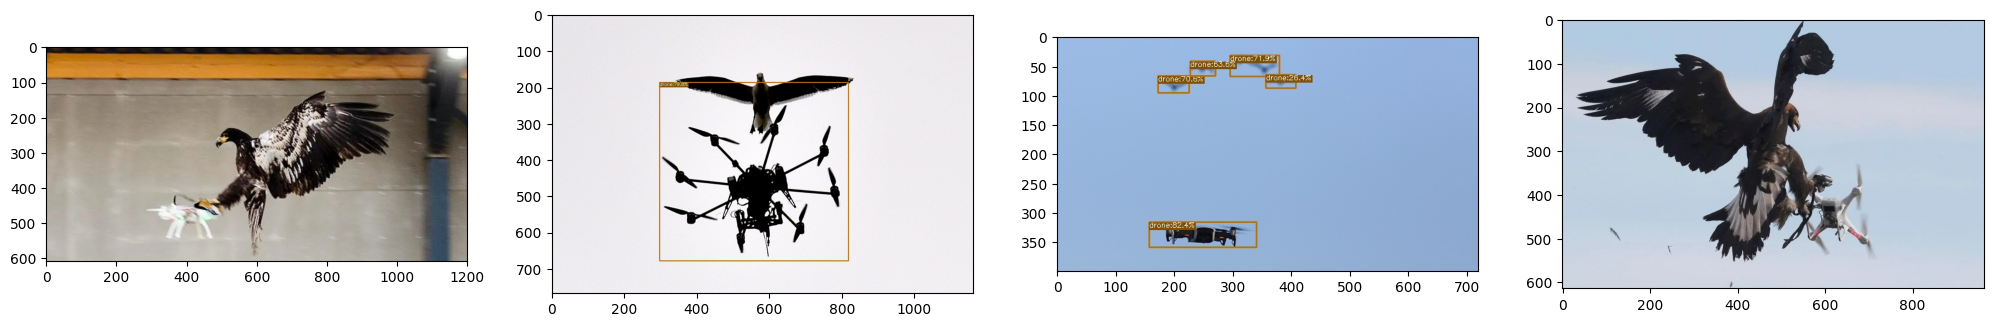

In [33]:
plt.figure(figsize=(25,15))
for i in range(len(images)):
  plt.subplot(1, len(images), i+1);
  plt.imshow(images[i][...,::-1]);

## 10. Video Inference

In [34]:
!wget https://www.dropbox.com/s/u1kqu0yxj07e35e/Drones-1-original.mp4?dl=1 -O Drones-1-original.mp4 -qq --show-progress

Drones-1-original.m 100%[===================>]   2.08M  --.-KB/s    in 0.07s   


In [35]:
!python tools/demo.py video -f exps/ExpConfigs/yolox_voc_m.py -c {MODEL_PATH} --path Drones-1-original.mp4 --conf 0.25 --nms 0.45 --tsize 640 --save_result --device gpu

2025-07-31 06:26:36.712 | INFO     | __main__:main:259 - Args: Namespace(demo='video', experiment_name='yolox_voc_m', name=None, path='Drones-1-original.mp4', camid=0, save_result=True, exp_file='exps/ExpConfigs/yolox_voc_m.py', ckpt='YOLOX_outputs/yolox_voc_m/best_ckpt.pth', device='gpu', conf=0.25, nms=0.45, tsize=640, fp16=False, legacy=False, fuse=False, trt=False)
2025-07-31 06:26:37.312 | INFO     | __main__:main:269 - Model Summary: Params: 25.28M, Gflops: 73.73
2025-07-31 06:26:37.517 | INFO     | __main__:main:282 - loading checkpoint
2025-07-31 06:26:37.735 | INFO     | __main__:main:286 - loaded checkpoint done.
2025-07-31 06:26:37.851 | INFO     | __main__:imageflow_demo:223 - video save_path is ./YOLOX_outputs/yolox_voc_m/vis_res/2025_07_31_06_26_37/Drones-1-original.mp4
2025-07-31 06:26:38.333 | INFO     | __main__:inference:165 - Infer time: 0.4382s
2025-07-31 06:26:38.396 | INFO     | __main__:inference:165 - Infer time: 0.0377s
2025-07-31 06:26:38.449 | INFO     | __ma

In [37]:
%cd ..


/content


In [38]:
!ls

sample_data  YOLOX


In [39]:
import shutil
shutil.make_archive('YOLOX','zip','YOLOX')

'/content/YOLOX.zip'